In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
import sys
import os

import numpy as np
import random 
import tensorflow as tf

from tensorflow import keras
from keras import layers

from matplotlib import pyplot as plt

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from datetime import datetime

utils.reset_seeds(0)

# 
Stackoverflow mis kinnitab praegust valemit: https://stats.stackexchange.com/questions/521091/optimizing-gaussian-negative-log-likelihood

In [3]:
# mean, sigma
# sigma on std ehk sqrt(variance) (see teine argument)
sigma = 0.1
logvar = np.log(sigma**2)
print(f"sigma: {sigma}, logvar: {logvar:.2f}")
y_train = np.random.normal(0, sigma, 1000)

uuringuruum = np.linspace(-2.5, 2, 1000)

sigma: 0.1, logvar: -4.61


In [4]:
tul = []

for i in uuringuruum:
   tul.append(utils.neg_log_likelihood(y_train, np.tile([0,i], (len(y_train), 1))))


print(np.min(tul), uuringuruum[np.argmin(tul)]) # np.argmin(tul),
print(f"hinnatud variance {np.exp(uuringuruum[np.argmin(tul)])**0.5}")# hinnatud variance

-1.468012874667435 -1.9684684684684686
hinnatud variance 0.3737253034320568


In [5]:
print(f"tegelik variance: {np.var(y_train):.4f}")

tegelik variance: 0.0097


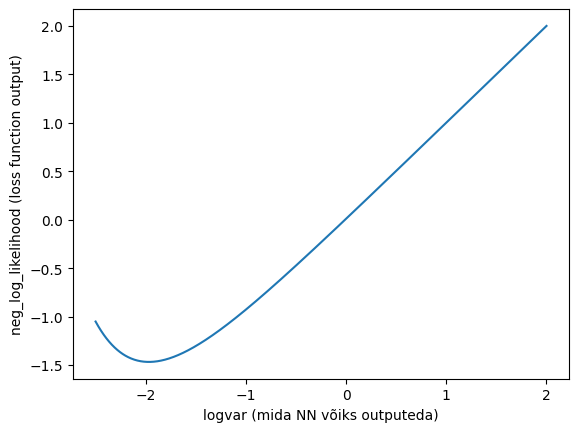

In [6]:
plt.plot(uuringuruum, tul)
plt.xlabel("logvar (mida NN võiks outputeda)")
plt.ylabel("neg_log_likelihood (loss function output)")
plt.show()

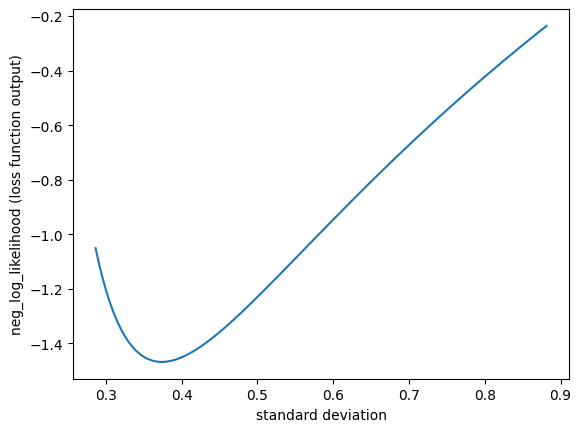

In [7]:
plt.plot((np.exp(uuringuruum)**0.5)[:500], tul[:500])
plt.xlabel("standard deviation")
plt.ylabel("neg_log_likelihood (loss function output)")
plt.show()

## Tegelik variance vs hinnatud variance (from neg_log_loss)

In [83]:
hinnatudstd = list()
tegelikstd = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,
              0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.]

for sigma in tegelikstd:

    logvar = np.log(sigma**2)
    print(f"sigma: {sigma}, logvar: {logvar:.2f}")

    y_train = np.random.normal(0, sigma, 1000)
    if sigma <= 0.1:
        uuringuruum = np.linspace(-7, -1, 1000)
    else:
        uuringuruum = np.linspace(-3, 2, 1000)
    tul = []

    for i in uuringuruum:
        tul.append(utils.neg_log_likelihood(
            y_train, np.tile([0, i], (len(y_train), 1))))

    print("minimum, logvar, sigma")
    print(np.min(tul), uuringuruum[np.argmin(tul)],
          np.exp(uuringuruum[np.argmin(tul)])**0.5)

    hinnatudstd.append(np.exp(uuringuruum[np.argmin(tul)])**0.5)


sigma: 0.05, logvar: -5.99
minimum, logvar, sigma
-2.1495408790054586 -2.651651651651652 0.26558354275303836
sigma: 0.1, logvar: -4.61
minimum, logvar, sigma
-1.468851016806247 -1.9669669669669672 0.37400598333132223
sigma: 0.15, logvar: -3.79
minimum, logvar, sigma
-1.0498833311819171 -1.5485485485485486 0.46103824693536344
sigma: 0.2, logvar: -3.22
minimum, logvar, sigma
-0.7409467875869618 -1.2432432432432432 0.537072802185861
sigma: 0.25, logvar: -2.77
minimum, logvar, sigma
-0.5422091999384956 -1.043043043043043 0.5936166599783643
sigma: 0.3, logvar: -2.41
minimum, logvar, sigma
-0.3503337799504839 -0.8478478478478477 0.6544736698036945
sigma: 0.35, logvar: -2.10
minimum, logvar, sigma
-0.19236527119121022 -0.6926926926926926 0.7072674851718095
sigma: 0.4, logvar: -1.83
minimum, logvar, sigma
-0.10208049218630104 -0.6026026026026026 0.7398548199403869
sigma: 0.45, logvar: -1.60
minimum, logvar, sigma
0.05299129278663923 -0.44744744744744747 0.7995359966863643
sigma: 0.5, logvar: -

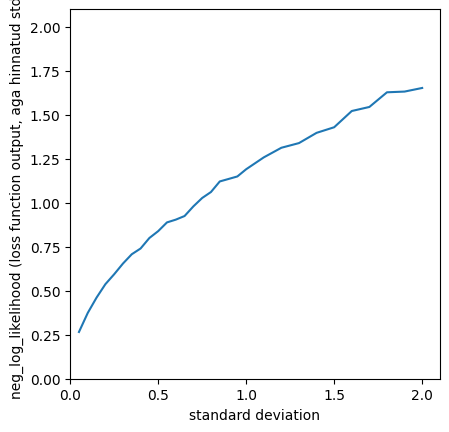

In [108]:
plt.plot(tegelikstd, hinnatudstd)
plt.axis("square")
plt.xlim(0, 2.1)
plt.ylim(0, 2.1)
plt.xlabel("standard deviation")
plt.ylabel("neg_log_likelihood (loss function output, aga hinnatud std)")
plt.show()

In [85]:
from scipy.optimize import minimize    

In [109]:
utils.neg_log_likelihood(y_train, np.tile([0, 0.3], (len(y_train), 1))).numpy()

0.30561440696962733

1.0512710963760241

In [8]:
import scipy.optimize as sco
import scipy.stats as scs

In [181]:
type(y_train)
y_train.shape

(1000,)

In [187]:
print(type([[0, i] for _ in range(1000)]))
print(len([[0, i] for _ in range(1000)]))
print(type([[0, i] for _ in range(1000)][0]))
print(len([[0, i] for _ in range(1000)][0]))

<class 'list'>
1000
<class 'list'>
2


In [199]:
for i in np.linspace(-2.5, 2, 1000):
    tul.append(utils.neg_log_likelihood(y_train, np.asarray([[0, 1.0] for _ in range(1000)])))

In [207]:
np.float64(1)

1.0

In [ ]:
tf.keras.losses.negloglik

In [9]:
def leia_min_kadu(logvar):
    global y_train
    # objective on leida vähim logvar, mis annab neg_log_likelihoodi minimumi kätte
    # print("logvar on " + logvar)
    # sys.stdout.flush()
    sigma_guess = np.exp(logvar)**0.5
    # # print(logvar)
    # print("sigmaguess on " + sigma_guess)
    # sys.stdout.flush()
    # print('Hello from the child process')
    # sys.stdout.flush()

    ret_val = utils.neg_log_likelihood(
        y_train, np.asarray([[0, np.float64(sigma_guess)] for _ in range(1000)])).numpy()
    # print(ret_val)
    return (ret_val)


tegelikstd = np.linspace(0.05, 5, 200)
scipy_var = []
for std in tegelikstd:
    y_train = np.random.normal(0, std, 1000)
    res = sco.minimize(leia_min_kadu, [0.2],)
    #print(res)
    scipy_var.append(res.x[0])

In [10]:
np.max(np.exp(scipy_var)**0.5)

5.081040870873502

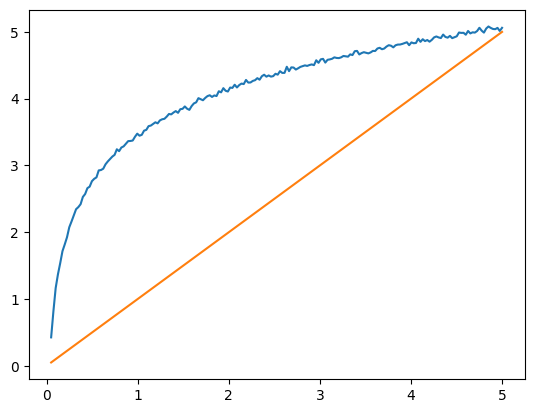

In [11]:
plt.plot(tegelikstd, np.exp(scipy_var)**0.5)
plt.plot(tegelikstd, tegelikstd)
plt.show()

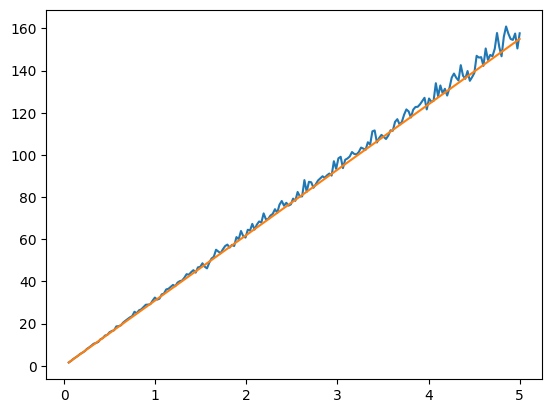

In [24]:
plt.plot(tegelikstd, np.exp(np.exp(scipy_var)**0.5))
plt.plot(tegelikstd, tegelikstd*np.pi**3)

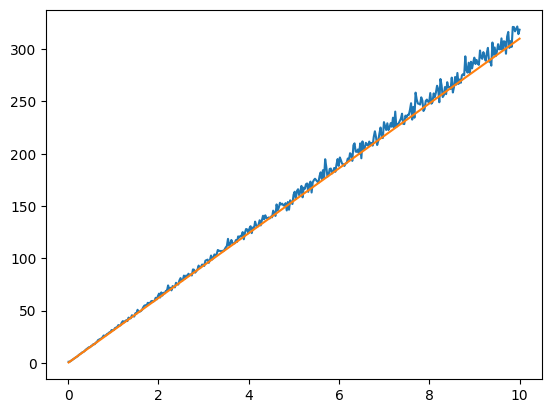

In [39]:
tegelikstd = np.linspace(0.01, 10, 400)
log_var_scipy2 = []
for std in tegelikstd:
    y_train = np.random.normal(0, std, 1000)
    res = sco.minimize(leia_min_kadu, [0.2],)
    #print(res)
    log_var_scipy2.append(res.x[0])
    
plt.plot(tegelikstd, np.exp(np.exp(log_var_scipy2)**0.5))
plt.plot(tegelikstd, tegelikstd*np.pi**3)

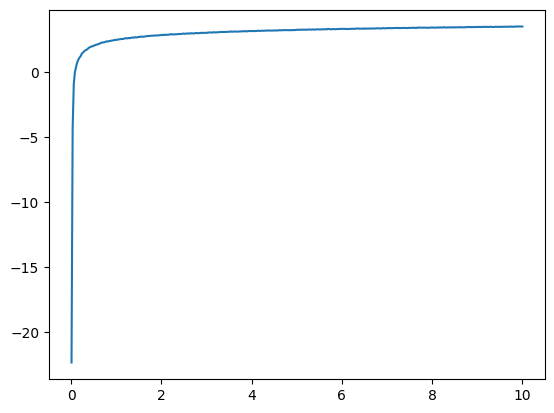

In [62]:
tegelikstd = np.linspace(0.01, 10, 400)

    
plt.plot(tegelikstd, log_var_scipy2)
#plt.plot(tegelikstd, tegelikstd)

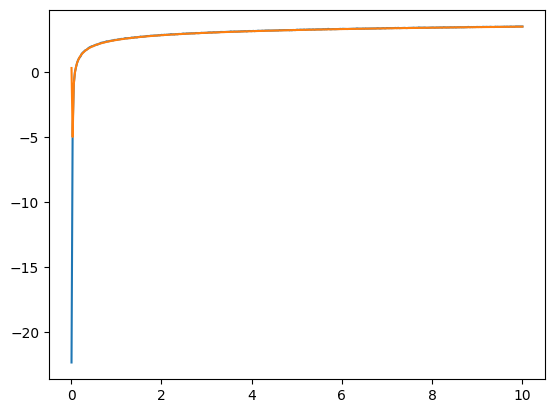

In [51]:
plt.plot(tegelikstd, log_var_scipy2)
plt.plot(tegelikstd, np.log(np.log(tegelikstd*np.pi**3)**2))

In [52]:
std = 10
mini, maxi = 10, 0.01
for i in range(100):
    y_train = np.random.normal(0, std, 1000)
    res = sco.minimize(leia_min_kadu, [0.2],)
    mini = min(mini, res.x[0])
    maxi = max(maxi, res.x[0])

In [53]:
print(mini, maxi, maxi-mini)

3.48376443570733 3.5166562182487646 0.032891782541434544


In [54]:
(maxi-mini)/mini

0.00944144851021086

In [302]:
(np.exp(np.exp(3.517766636053372)**0.5) - np.exp(np.exp(3.4813063246810505)**0.5)) /np.exp(np.exp(3.4813063246810505)**0.5)

0.11058226914294493

# Vastuseks on np.log(tegelikstd)+ 3*np.log(np.pi)?

In [308]:
3*np.log(np.pi)

3.4341896575482007

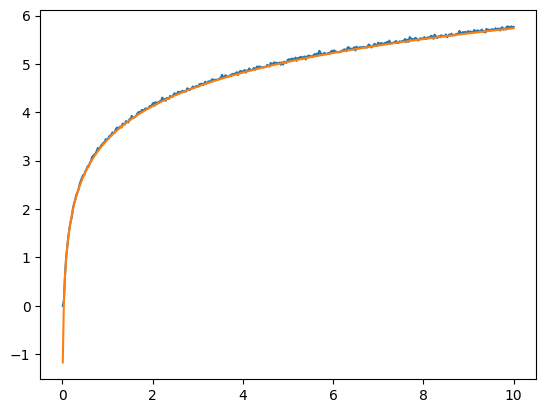

In [60]:
plt.plot(tegelikstd, np.exp(log_var_scipy2)**0.5) # siin oli logvar, millest saab exp tõttu var, millest võtame ruutjuure ja saame std
# ehk sinine on kao-fni poolt leitav std
plt.plot(tegelikstd, np.log(tegelikstd)+ 3*np.log(np.pi))
# ehk oranž on kuidas tegelik std muundada selleiseks nagu see kao-fn annab

# Kasutame seda neglogloss2

In [311]:
def leia_min_kadu2(logvar):
    global y_train
    sigma_guess = np.exp(logvar)**0.5
    ret_val = utils.neg_log_likelihood2(
        y_train, np.asarray([[0, np.float64(sigma_guess)] for _ in range(1000)])).numpy()
    # print(ret_val)
    return (ret_val)

# tegelikstd = np.linspace(0.05, 5, 200)
# scipy_var = []
# for std in tegelikstd:
#     y_train = np.random.normal(0, std, 1000)
#     res = sco.minimize(leia_min_kadu2, [0.2],)
#     #print(res)
#     scipy_var.append(res.x[0])

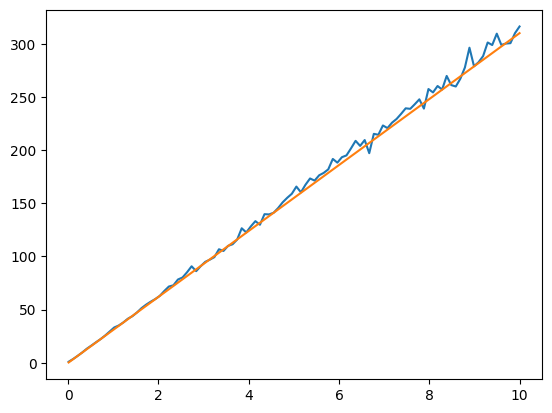

In [313]:
tegelikstd = np.linspace(0.01, 10, 100)
log_var_scipy3 = []
for std in tegelikstd:
    y_train = np.random.normal(0, std, 1000)
    res = sco.minimize(leia_min_kadu2, [0.2],)
    log_var_scipy3.append(res.x[0])
    
plt.plot(tegelikstd, np.exp(np.exp(log_var_scipy3)**0.5))
plt.plot(tegelikstd, tegelikstd*np.pi**3)

In [98]:
utils.neg_log_likelihood(y_train, np.asarray([[0, np.float64(0.43)] for _ in range(1000)])).numpy()

11.583412502785759

In [114]:
def leia_min_kadu3(logvar, y_train):
    #global y_train
    
    #sigma_guess = np.exp(logvar)**0.5
    ret_val = utils.neg_log_likelihood(
        y_train, np.asarray([[0, np.float64(logvar)] for _ in range(1000)])).numpy()
    # print(ret_val)
    return (ret_val)

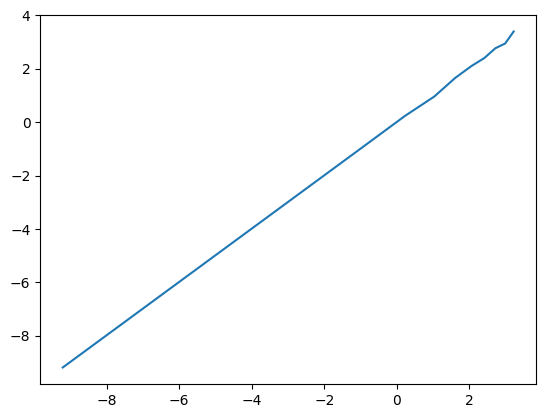

In [123]:
tegelikstd = np.linspace(0.01, 5, 10)
log_var_scipy3 = []
tegelik_mse = []
for std in tegelikstd:
    y_train = np.random.normal(0, std, 1000)
    res = sco.minimize(leia_min_kadu3, [0.6], args=(y_train),)
    #print(res)
    log_var_scipy3.append(res.x[0])
    tegelik_mse.append(np.mean(y_train**2))
    
plt.plot(np.log(tegelikstd**2), log_var_scipy3)
#plt.plot(tegelikstd, tegelikstd*np.pi**3)

In [122]:
np.log(1.7)

0.5306282510621704

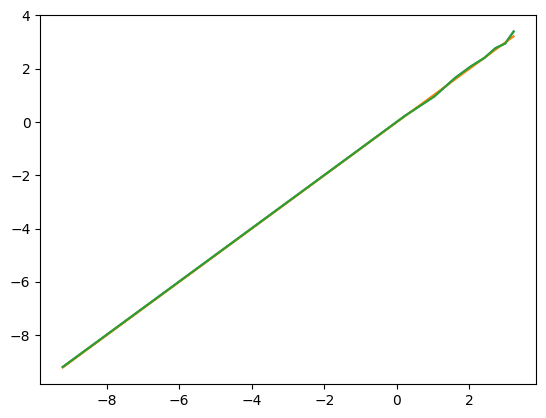

In [124]:
plt.plot(np.log(tegelikstd**2), log_var_scipy3)
plt.plot(np.log(tegelikstd**2), np.log(tegelikstd**2))
plt.plot(np.log(tegelikstd**2), np.log(tegelik_mse))

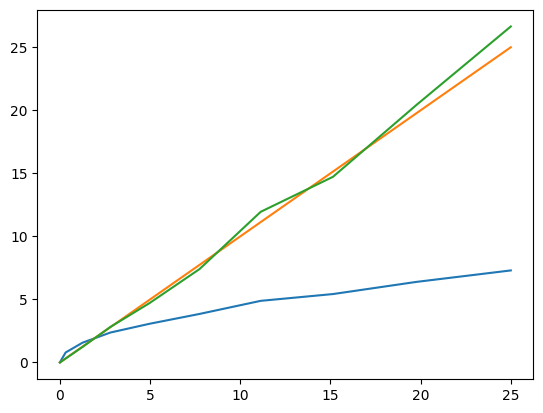

In [117]:
plt.plot(tegelikstd**2, np.exp(log_var_scipy3)) # kaofn minimum
plt.plot(tegelikstd**2, tegelikstd**2) # variance
plt.plot(tegelikstd**2, tegelik_mse) # mse
# MSE on sama kui Variance

In [93]:
np.log(tegelikstd)

array([-4.60517019, -2.80669928, -2.19995558, -1.82503426, -1.5529812 ,
       -1.33933367, -1.16339326, -1.01382561, -0.88374532, -0.76865473,
       -0.66545341, -0.57191332, -0.48637941, -0.40758857, -0.33455488,
       -0.26649399, -0.20277167, -0.14286777, -0.08635044, -0.03285717,
        0.01791929,  0.06624162,  0.11233613,  0.15639923,  0.19860244,
        0.23909643,  0.27801428,  0.31547409,  0.35158118,  0.38642986,
        0.4201049 ,  0.45268277,  0.48423272,  0.51481765,  0.54449483,
        0.5733166 ,  0.60133089,  0.62858172,  0.65510961,  0.68095191,
        0.70614317,  0.7307154 ,  0.75469829,  0.77811944,  0.80100458,
        0.82337768,  0.84526116,  0.86667599,  0.88764182,  0.9081771 ,
        0.92829915,  0.94802428,  0.96736784,  0.98634432,  1.00496739,
        1.02324997,  1.04120429,  1.05884193,  1.07617387,  1.09321052,
        1.10996178,  1.12643705,  1.14264528,  1.15859499,  1.1742943 ,
        1.18975094,  1.2049723 ,  1.21996545,  1.23473712,  1.24

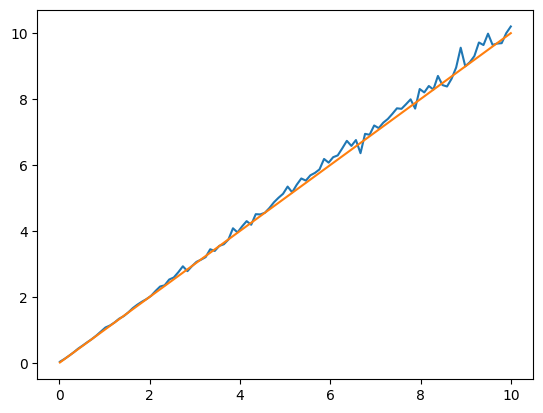

In [324]:
plt.plot(tegelikstd, np.exp(np.exp(log_var_scipy3)**0.5)/np.pi**3)
plt.plot(tegelikstd, tegelikstd)

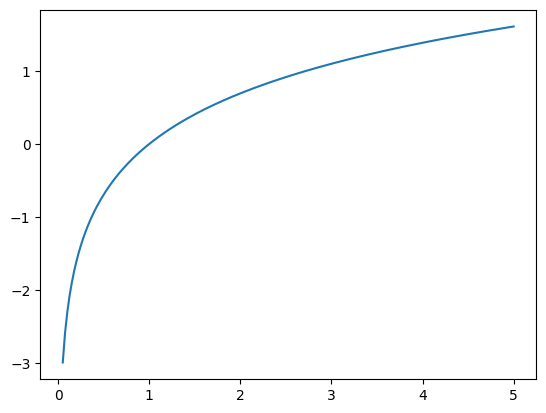

In [244]:
plt.plot(np.linspace(0.05, 5, 200), np.log(np.linspace(0.05, 5, 200)))

In [168]:
def squared(x):
    return tf.reduce_sum(tf.square(x))

res = sco.minimize(squared, 100)
res.x

array([-7.45122473e-09])

In [ ]:

# hinnatudstd = list()
# tegelikstd = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,
#               0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.]

# for sigma in tegelikstd:

#     logvar = np.log(sigma**2)
#     print(f"sigma: {sigma}, logvar: {logvar:.2f}")

#     y_train = np.random.normal(0, sigma, 1000)
#     if sigma <= 0.1:
#         uuringuruum = np.linspace(-7, -1, 1000)
#     else:
#         uuringuruum = np.linspace(-3, 2, 1000)
#     tul = []

#     for i in uuringuruum:
#         tul.append(utils.neg_log_likelihood(
#             y_train, np.tile([0, i], (len(y_train), 1))))

#     print("minimum, logvar, sigma")
#     print(np.min(tul), uuringuruum[np.argmin(tul)],
#           np.exp(uuringuruum[np.argmin(tul)])**0.5)

#     hinnatudstd.append(np.exp(uuringuruum[np.argmin(tul)])**0.5)

In [ ]:
tul = []
y_train = np.random.normal(0, 0.1, 1000)


for i in np.linspace(-2.5, 2, 1000):
    tul.append(utils.neg_log_likelihood2(y_train, np.asarray([[0, i] for _ in range(1000)])))
plt.plot(np.linspace(-2.5, 2, 1000), tul)
print(np.min(tul), np.linspace(-2.5, 2, 1000)[np.argmin(tul)]) # np.argmin(tul),
print(np.exp(np.linspace(-2.5, 2, 1000)[np.argmin(tul)])**0.5 )# hinnatud variance

## Joonistame parandatud funkiga

In [58]:

def joonista_variance(m: tf.keras.Sequential, X_test, X_train, y_train=None, bpoint_fn=Slopes.breakpoint_finder, *, ground_truth=False, xlim=None, ylim=None, returnplt=False):
    def _correctionfunc(x):             
        return np.log(np.log(x*np.pi**3)**2)
        #return np.exp(np.exp(x)**0.5)/np.pi**3


    # for each prediction, plot the mean value and the variance of the prediction
    if y_train is None:
        y_train = X_train**2

    bpoints = bpoint_fn(m, X_test)

    _patterns = [bp[1] for bp in bpoints]
    bpoints = [bp[0] for bp in bpoints]


    print(f"model contains {len(bpoints)} breaks")

    y_pred = m.predict(X_test)
    # print(y_pred)
    y_pred_mean, y_pred_logvar = y_pred[:, 0], y_pred[:, 1]
    y_pred_var = _correctionfunc(np.exp(y_pred_logvar))


    plt.xlim(xlim)
    plt.ylim(ylim)

    # absoluutselt õige
    if ground_truth:
        plt.plot(np.linspace(-1,1,1000), ground_truth(np.linspace(-1,1,1000)), label="õige", alpha=0.5, color="yellow")
    
    plt.plot(X_test, y_pred_mean, label="mean")
    plt.fill_between(X_test, y_pred_mean - y_pred_var,
                     y_pred_mean + y_pred_var, alpha=0.2, label="variance")
    plt.scatter(X_train, y_train, marker='+', color="red", label="train")

    temp_bpoints = list(zip(*bpoints))
    bx, by = temp_bpoints[0], temp_bpoints[1]

    plt.scatter(bx, by, marker="o", color="green", label="breaks")

    plt.legend()

    if returnplt:
        return plt
    
    plt.show()

Epoch:   0 | Loss: 3.89868e-01
Epoch: 100 | Loss: -1.67941e+00
Epoch: 200 | Loss: -2.94802e+00
Epoch: 300 | Loss: -3.20531e+00
Epoch: 400 | Loss: -3.29190e+00
Epoch: 500 | Loss: -3.33289e+00
Epoch: 600 | Loss: -3.35555e+00
Epoch: 700 | Loss: -3.37977e+00
Epoch: 800 | Loss: -3.39183e+00
Epoch: 900 | Loss: -3.40715e+00
313/313 [==============================] - 1s 4ms/step
model contains 7 breaks
313/313 [==============================] - 1s 4ms/step


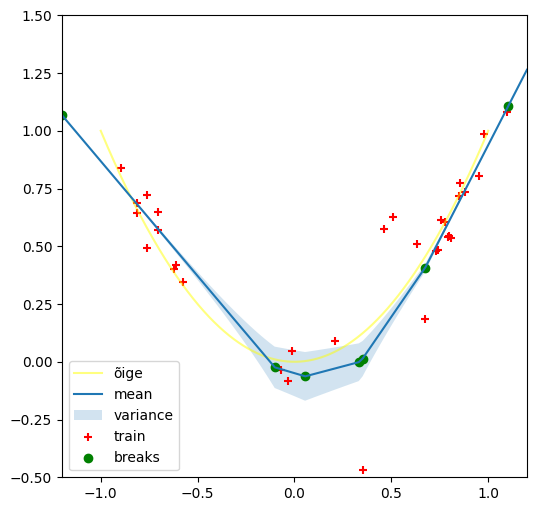

In [125]:
utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=5, activation='relu', name="layer_1"),
    layers.Dense(units=5, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])
X, y = utils.train_data_maker([
    (-0.8, 0.1, 10, 0.1),
    (0.5, 0.2, 10, 0.3),
    (0.9, 0.1, 10, 0.1),
    (0, 0.1, 2, 0.05)])

X_train, y_train = X, y
X_valid, y_valid = np.linspace(-1.2, 1.2,
                               10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.001, amsgrad=True, epsilon=0.001),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X, y, batch_size=8, epochs=1000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)


utils.joonista_variance(model, X_valid, X_train, y_train, ground_truth=lambda x:x**2, xlim=(-1.2, 1.2), ylim=(-0.5, 1.5))

313/313 [==============================] - 1s 4ms/step
model contains 7 breaks
313/313 [==============================] - 1s 3ms/step


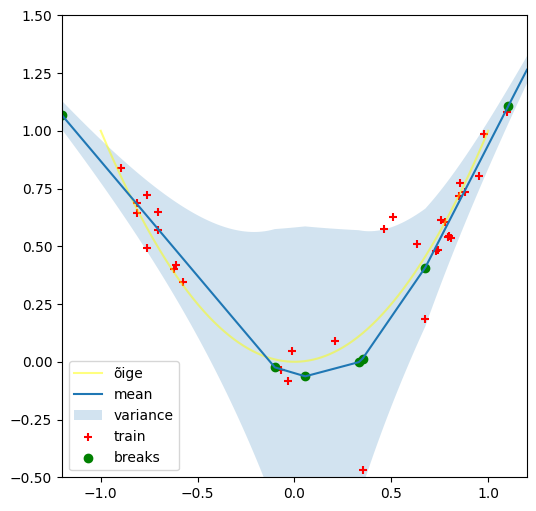

In [126]:
utils.joonista_variance(model, X_valid, X_train, y_train, ground_truth=lambda x:x**2, xlim=(-1.2, 1.2), ylim=(-0.5, 1.5))

Epoch:   0 | Loss: 1.67727e-01
Epoch: 100 | Loss: -6.08549e-01
Epoch: 200 | Loss: -7.59644e-01
Epoch: 300 | Loss: -7.64154e-01
Epoch: 400 | Loss: -7.64136e-01
Epoch: 500 | Loss: -7.63729e-01
Epoch: 600 | Loss: -7.64185e-01
Epoch: 700 | Loss: -7.64286e-01
Epoch: 800 | Loss: -7.63838e-01
Epoch: 900 | Loss: -7.64069e-01
313/313 [==============================] - 1s 3ms/step
model contains 2 breaks
313/313 [==============================] - 1s 3ms/step


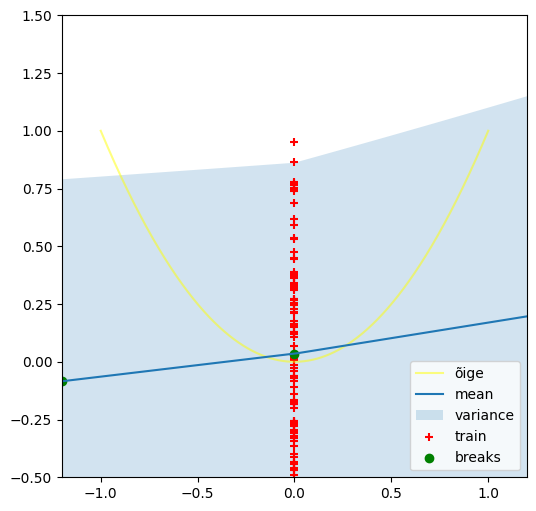

In [129]:
utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=5, activation='relu', name="layer_1"),
    layers.Dense(units=5, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])
X, y = utils.train_data_maker([
    (0, 0.0, 100, 0.4)],
    fn=lambda x: x**2
    )

X_train, y_train = X, y
X_valid, y_valid = np.linspace(-1.2, 1.2,
                               10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.001, amsgrad=True, epsilon=0.001),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X, y, batch_size=8, epochs=1000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)


utils.joonista_variance(model, X_valid, X_train, y_train, ground_truth=lambda x:x**2, xlim=(-1.2, 1.2), ylim=(-0.5, 1.5))

In [130]:
def find_rmse_estimate(model, X_train, y_train): # treeningandmetel mitte gridil
    X = X_train
    num = len(X)

    y_pred = model.predict(X)
    variance = np.exp(y_pred[:, 1:])

    return np.sqrt(np.sum(variance)/num)

find_rmse_estimate(model, X_train, 1)

4/4 [==============================] - 0s 2ms/step


0.41333457444117444

In [361]:
model.predict(np.linspace(-1, 1, 1000))

32/32 [==============================] - 0s 1ms/step


array([[ 0.3536821 , -0.7392765 ],
       [ 0.3536821 , -0.7392765 ],
       [ 0.3536821 , -0.7392765 ],
       ...,
       [ 0.9263754 , -2.885447  ],
       [ 0.92962736, -2.8928933 ],
       [ 0.9328798 , -2.90034   ]], dtype=float32)

313/313 [==============================] - 0s 1ms/step
model contains 9 breaks
313/313 [==============================] - 0s 1ms/step


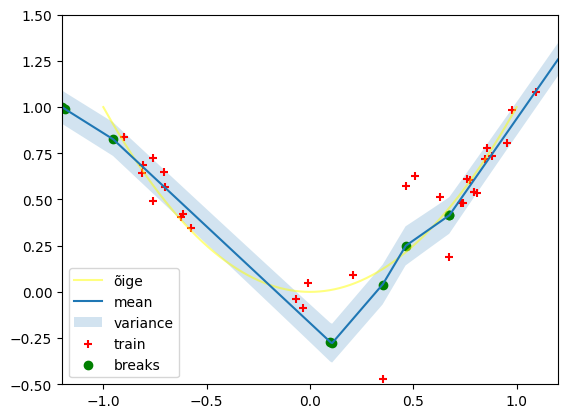

In [371]:
joonista_variance(model, X_valid, X_train, y_train, xlim=(-1.2,1.2), ylim=(-0.5,1.5),
                        ground_truth=lambda x: x**2)

In [64]:
utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=5, activation='relu', name="layer_1", kernel_initializer=keras.initializers.RandomNormal(mean=1, stddev=0.01),),
    layers.Dense(units=5, activation='relu', name="layer_2", kernel_initializer=keras.initializers.RandomNormal(mean=1, stddev=0.01)),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

fn = lambda x: x**2
X, y = utils.train_data_maker([
    (-0.8, 0.1, 10, 0.1),
    (0.5, 0.2, 10, 0.3),
    (0.9, 0.1, 10, 0.1),
    (0, 0.1, 2, 0.05)],
    fn=fn
    )

X_train, y_train = X, y
X_valid, y_valid = np.linspace(-1.2, 1.2,1000), fn(np.linspace(-1.2, 1.2, 1000))

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.001, amsgrad=True, epsilon=0.001),
    loss=tfp.experimental.nn.losses.negloglik,
)

h = model.fit(X, y, batch_size=8, epochs=1500, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

NameError: name 'tfp' is not defined

In [71]:
def leia_min_kadu3(logvar):
    global y_train
    sigma_guess = np.exp(logvar)**0.5
    ret_val = utils.nll_gaussian( np.zeros(1000),
        np.asarray([[np.float64(sigma_guess)] for _ in range(1000)]),
        y_train).numpy()
    # print(ret_val)
    return (ret_val)

tegelikstd = np.linspace(0.05, 5, 109)
scipy_var = []
for std in tegelikstd:
    y_train = np.random.normal(0, std, 1000)
    res = sco.minimize(leia_min_kadu3, [0.2],)
    #print(res)
    scipy_var.append(res.x[0])

In [74]:
scipy_var =np.asarray(scipy_var)

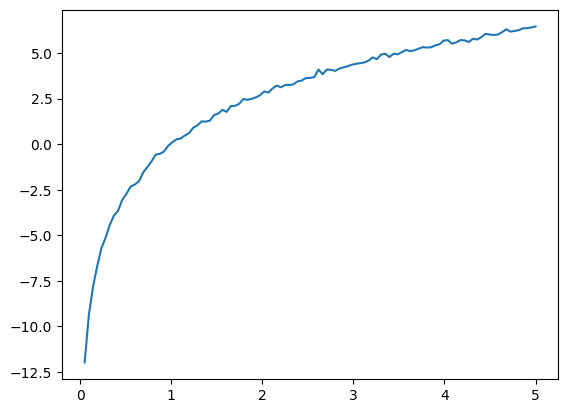

In [79]:
plt.plot(tegelikstd, scipy_var)
#plt.plot(tegelikstd, tegelikstd)

In [84]:
y = np.random.normal(0, 1.5, 1000)
print(np.var(y))
print(np.mean(y**2))

2.1385412046512706
2.1395221015015826
